In [1]:
#Function to pull data whenever needed
import os
import tarfile
from six.moves import urllib
#https://github.com/ageron/handson-ml/raw/master/datasets/housing/housing.tgz
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/raw/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
#fetch and load data
housing = load_housing_data()



In [4]:
#get some useful infor about the data
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#what kind of ocean_proximity object values are there?
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

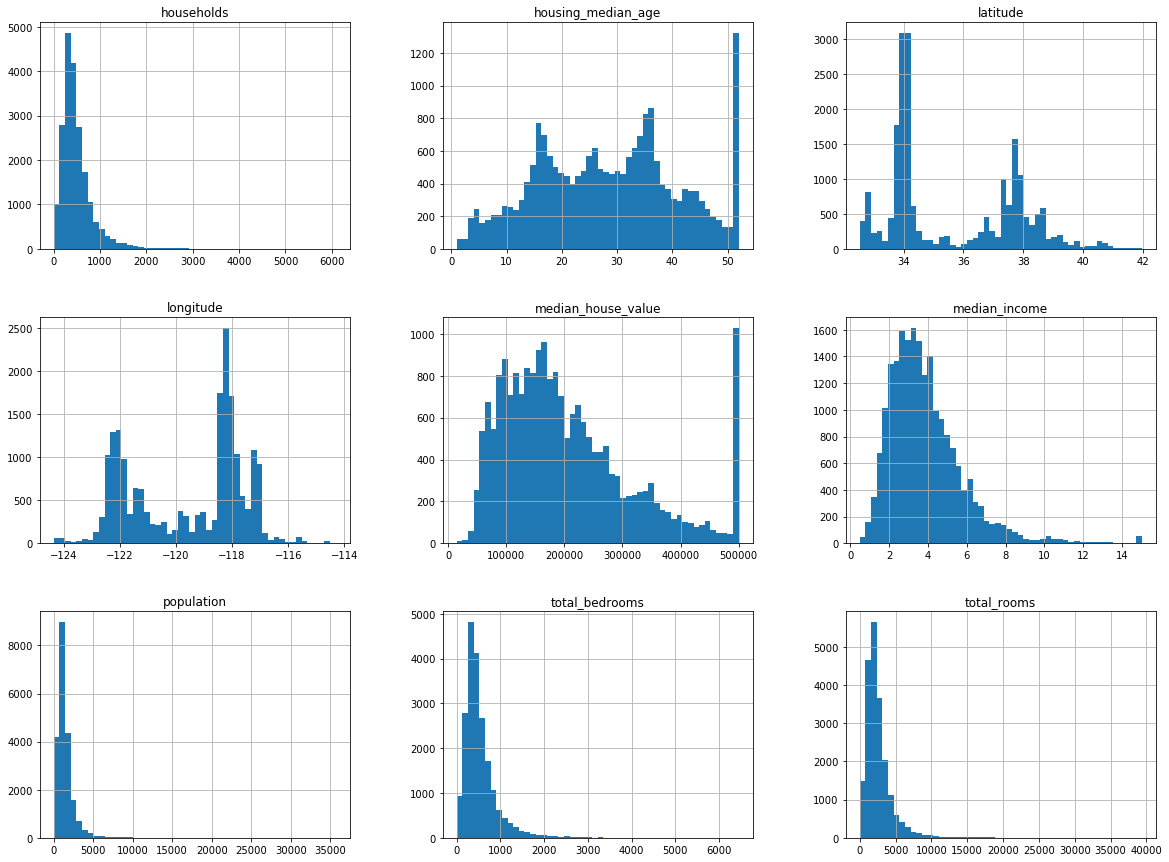

In [6]:
%matplotlib inline   
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
#split data in well representative set for median_incomde
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [8]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

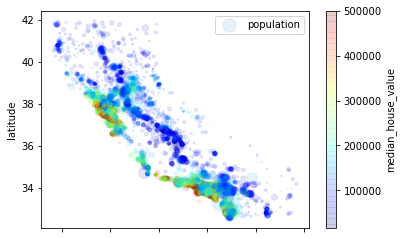

In [9]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,s=housing["population"]/100,
             label="population",c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()


In [10]:
#pearson's correlation matrix shows how positively or negatively correlated an attribute is
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120207908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a17d128>]], dtype=object)

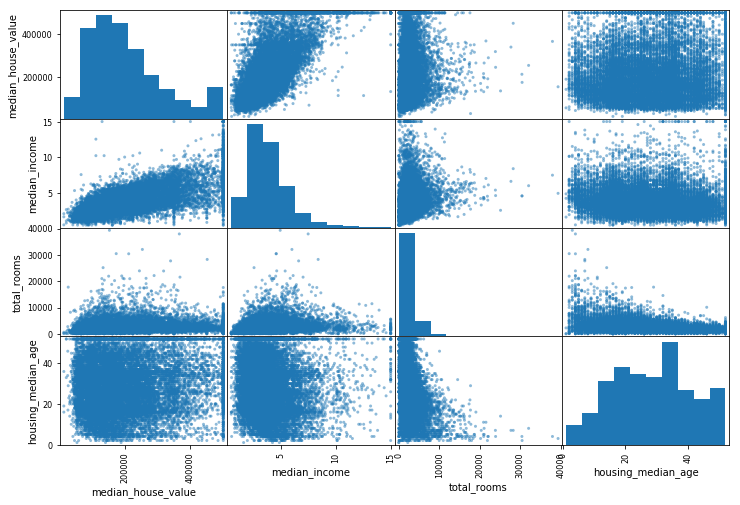

In [11]:
#pandas scatter mix plots every attribute to every other attribute
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

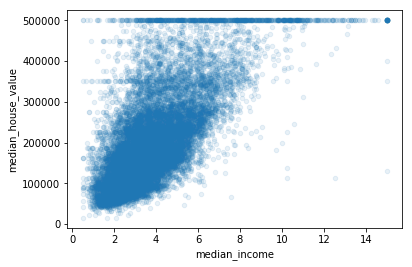

In [12]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

In [13]:
#engineer some attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [14]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"]

longitude                  -0.047432
latitude                   -0.142724
housing_median_age          0.114110
total_rooms                 0.135097
total_bedrooms              0.047689
population                 -0.026920
households                  0.064506
median_income               0.687160
median_house_value          1.000000
rooms_per_household         0.146285
bedrooms_per_room          -0.259984
population_per_household   -0.021985
Name: median_house_value, dtype: float64

In [15]:
#time to clean data before apply ml algorithms
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [23]:
from sklearn.preprocessing import Imputer

#imputer = Imputer(strategy="median")
#imputer can only work with numerical values
housing_num = housing.drop("ocean_proximity", axis=1)
#train imputer
#imputer.fit(housing_num)
#transform your data
#trans = imputer.transform(housing_num)
#housing_tr = pd.DataFrame(trans, columns=housing_num.columns)




In [24]:
#now time to work on the non numerical attributes
##you could use LabeEncoder
# from sklearn.preprocessing import LabelEncoder

# labelEncoder = LabelEncoder();
#housing_cat = housing["ocean_proximity"]
# labelEncoder.fit(housing_cat)
# labelEncoder.classes_
# housing_cat_encoded = labelEncoder.transform(housing_cat)
# housing_cat_encoded

#or use binarize encoder which does the integer and one hot encoding for you
from sklearn.preprocessing import LabelBinarizer

# lb = LabelBinarizer()
# housing_cat_1hot=lb.fit_transform(housing_cat)
# housing_cat_1hot

In [25]:
#You can also create your custom transformer --> feature engineering
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [26]:
#custom define a dataframe selector
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [27]:
class SupervisionFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(SupervisionFriendlyLabelBinarizer, self).fit_transform(X)

In [28]:
#use a full pipleline for complete transform
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', SupervisionFriendlyLabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [88]:
# now data is fully prepared
#Let's see how linear regression did on some of the data after fitting them to some line of best fit
from sklearn.linear_model import LinearRegression
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])
housing_prepared = full_pipeline_with_predictor.fit(housing, housing_labels)
lin_housing_predictions = full_pipeline_with_predictor.predict(some_data)
print("Predictions:\t",lin_housing_predictions)
print("Labels:\t",list(some_labels))


Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [92]:
#Linear regression mean squared error
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(housing_labels,full_pipeline_with_predictor.predict(housing))
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [94]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
housing_prepared = full_pipeline.fit_transform(housing)
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [95]:
#Overfitting ...
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [98]:
#lets use the scikit learn cross validation utitlity
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("Scores:", rmse_scores)
print("Mean Scores",rmse_scores.mean()) # worse than linear regression

Scores: [ 68439.85782436  67670.12271958  71574.0480702   71188.2746679
  70699.90590101  75253.31630206  69229.39637633  70843.20514519
  76168.54570292  70348.58314837]
Mean Scores 71141.5255858


In [106]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
housing_prepared = full_pipeline.fit_transform(housing)
forest_reg.fit(housing_prepared, housing_labels)
forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

22539.8921763


In [100]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print("Scores:", rmse_scores)
print("Mean Scores",rmse_scores.mean()) #Did much better than decision tree and linear regression

Scores: [ 52091.19765416  50625.63399416  51717.2330805   54348.24822387
  52389.95682847  56448.87874327  50552.04473357  50377.82960095
  54677.5281364   51791.71685404]
Mean Scores 52502.0267849


In [ ]:
#FYI
#Playing with hyper parameters using GridSearch, Randomized Search can help to finetune the model
#I might just pick the RandomForest method here for a second, although the training set score is still a bit low
